**Bank Marketing Campaign - Subscription to Term Deposit - Analysis & Prediction**

**Context:**
Outbound telemarketing is a proactive form of telemarketing which involves directly contacting existing and potential customers by telephone for increasing sales, promoting new products and services. For optimized use of resources in campaigns and to improve its effectiveness, it is important to identify the factors influencing a successful outcome and to pre-filter customers who are more likely to become a prospect.

**About the Dataset:**
This dataset has data related to direct marketing campaigns of a Portuguese banking institution. It has 20 attributes describing the customers who were contacted as part of the campaign, details related to the recent/previous campaigns and most interestingly enriched with the social and economic context attributes. It also includes one additional target attribute indicating if the customer eventually subscribed to the term deposit.

**Goal:**
The goal of this project is to analyze the dataset using exploratory data analysis methods to create a classification model that can predict based on the attributes of the dataset whether a customer will subscribe to a term deposit or not. Using classification algorithms like Multi Layer Perceptron and Random Forest Classification can help provide a way of accurately classifying customers who will “subscribe” to the deposit. Unlike other data science projects that have used this data, we will use SMOTE or Synthetic Minority Oversampling Technique to overcome class imbalance which otherwise could result in predictions that are biased towards the majority class. We will then summarize all three approaches towards the data in our conclusions and recommend the best approach based on the model’s performance metrics.



# Section 0 : Import necessary libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
import gc
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score,average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

#import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

# Section 1: Exploratory Data Analysis

In [ ]:
# Read data
data = pd.read_csv('bank-additional-full.csv', sep=';')
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))



'There is 41188 observations with 21 features'

In [ ]:
# Build a function to show categorical values disribution
def plot_bar(column):
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of customers')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();

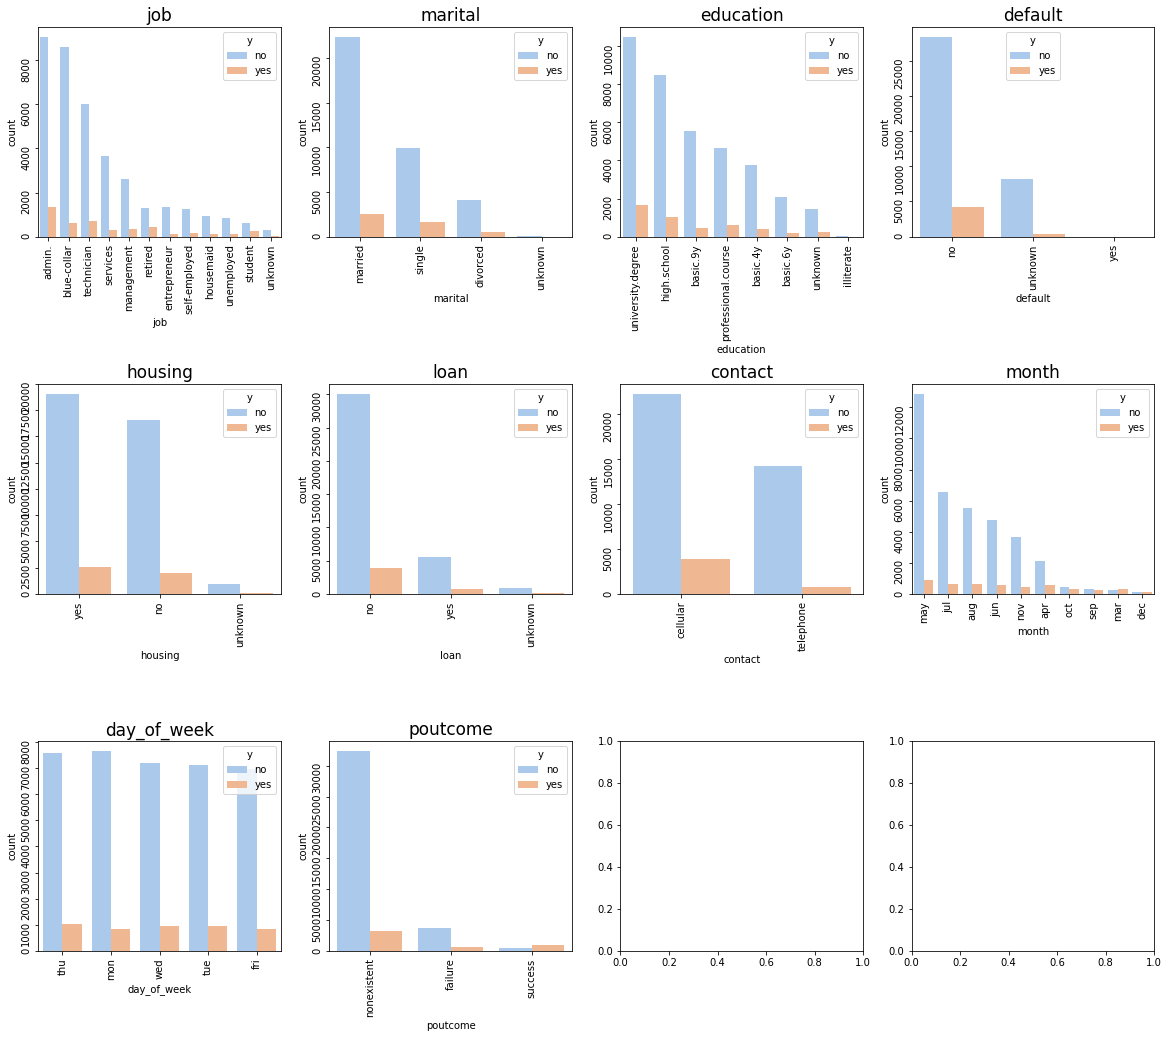

In [ ]:
# Build a function to show distribution of target labels for different values of categorical features
# Reference -- Previous work

fig, ax = plt.subplots(3,4, figsize=(20,17))

cat = data.select_dtypes('object').columns.to_list()
cat = cat[:-1]

ax = ax.ravel()
position = 0

for i in cat:

    order = data[i].value_counts().index
    sns.countplot(data=data, x=i, ax=ax[position], hue='y', palette='pastel', order=order)
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title(i, fontdict={'fontsize':17})

    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

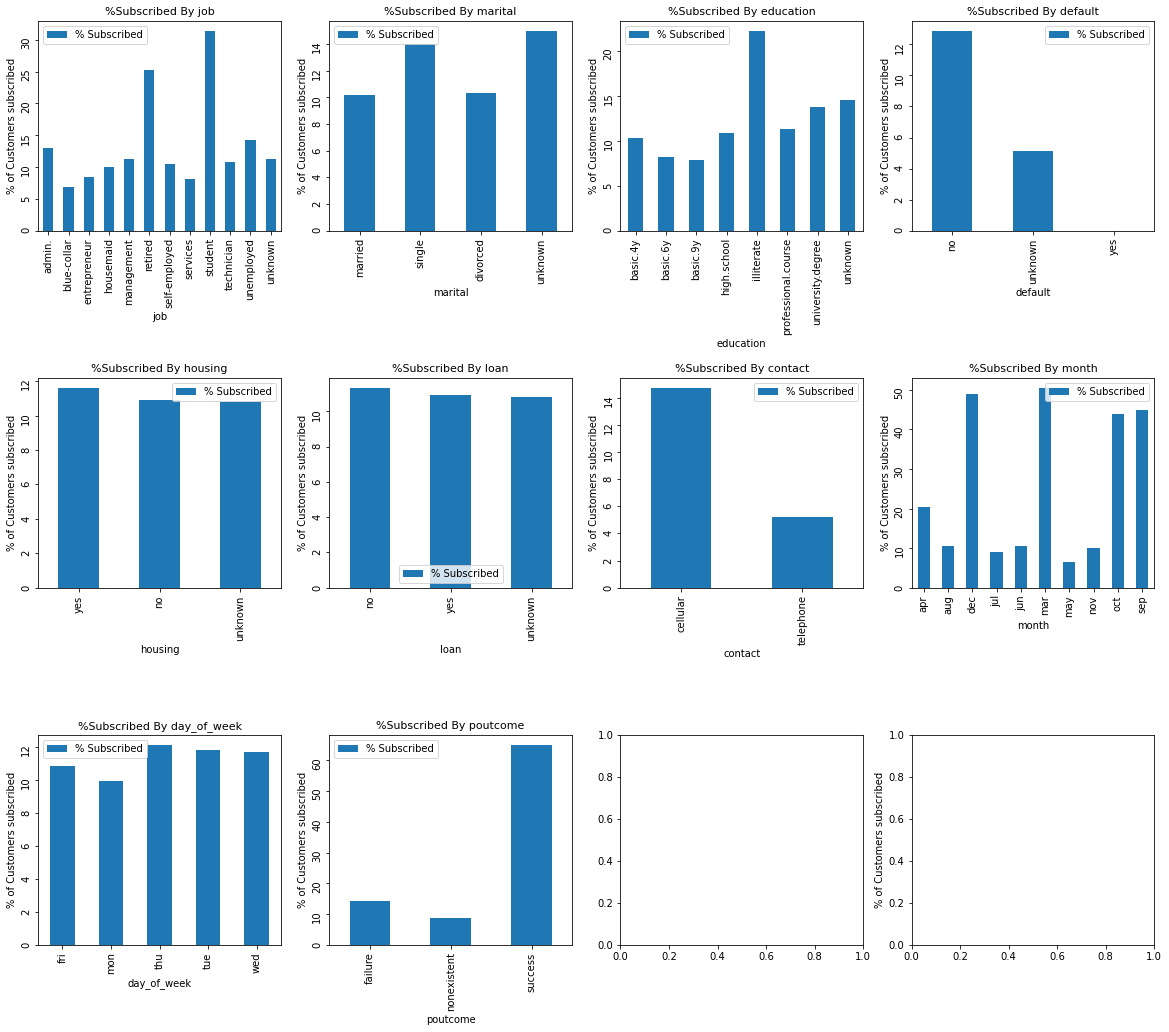

In [ ]:
# Build a function to show percent subscribed for each Categorical feature value
# Look for patterns or values that influence subscription
# ---- New Analysis by %Subscribed -----------------------

fig, ax = plt.subplots(3,4, figsize=(20,17))

cat = data.select_dtypes('object').columns.to_list()
cat = cat[:-1]


ax = ax.ravel()
position = 0

for i in cat:
    # temp df
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['% Subscribed'] = data[data['y'] == 'yes'][i].value_counts() *100 /(data[data['y'] == 'no'][i].value_counts() + data[data['y'] == 'yes'][i].value_counts())
    temp_1.plot(kind='bar', ax=ax[position], xlabel=i , ylabel ='% of Customers subscribed')
    plt.ylabel('% of Customers subscribed')
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title('%Subscribed By {}'.format(i), fontdict={'fontsize':11})

    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

In [ ]:
# Convert target from categorical to numerical
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

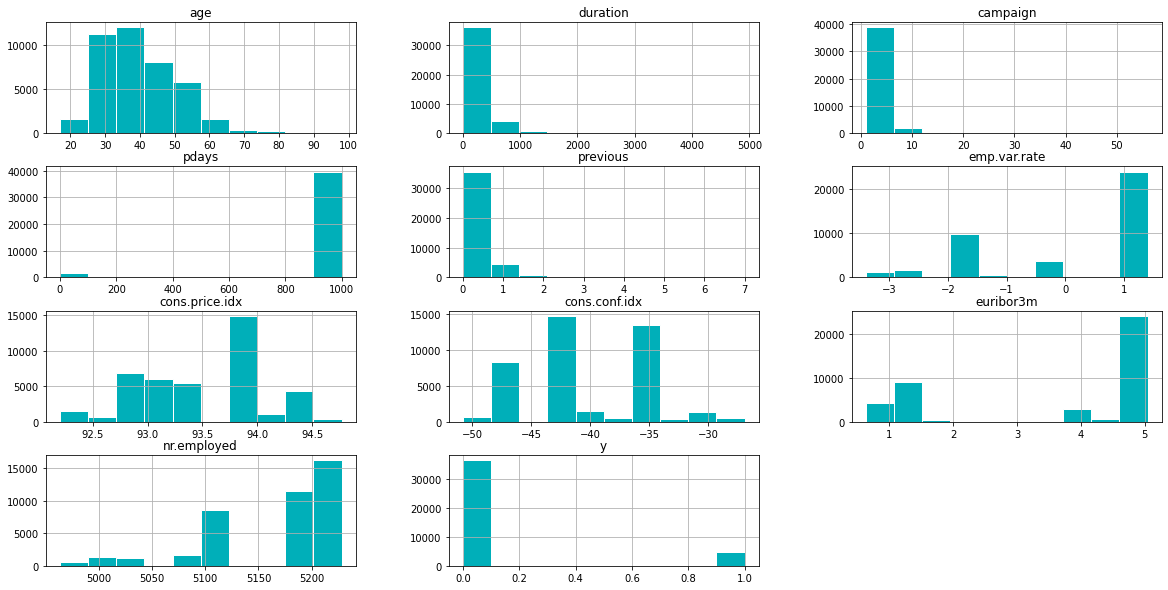

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [ ]:
# Distribution of numerical features
# Reference -- Previous work

data['month'] = data['month'].astype('str')
data['day_of_week'] = data['day_of_week'].astype('str')

numbers = data.select_dtypes(['int64', 'float64','uint8']).columns.to_list()
len(numbers)

data.hist(figsize=(20,10), edgecolor='white', color='#00afb9')
plt.show()

display(data[numbers].describe())

# Section 2 : Data Cleansing and transformation

In [ ]:
data['month'] = pd.to_datetime(data['month'], format='%b').dt.month
data['month'].value_counts().index

Int64Index([5, 7, 8, 6, 11, 4, 10, 9, 3, 12], dtype='int64')

In [ ]:
d = {'thu':4, 'mon':1, 'wed':3, 'tue':2, 'fri':5}
data['day_of_week'] = data['day_of_week'].map(d)
data['day_of_week'].value_counts().index

Int64Index([4, 1, 3, 2, 5], dtype='int64')

In [ ]:
def pcontacted(x):
    if x == 999:
        return 'no'
    else:
        return 'yes'

data['pdays'] = data['pdays'].apply(pcontacted)
data.rename(columns={"pdays": "bcontacted"}, inplace=True)
data['bcontacted'].value_counts()

no     39673
yes     1515
Name: bcontacted, dtype: int64

In [ ]:
# Drops nulls
def dropnulls(column):

    data[column].replace('unknown', np.nan, inplace=True)
    data.dropna(inplace=True)

dropnulls('job')
dropnulls('marital')
dropnulls('education')
dropnulls('housing')


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38245 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             38245 non-null  int64  
 1   job             38245 non-null  object 
 2   marital         38245 non-null  object 
 3   education       38245 non-null  object 
 4   default         38245 non-null  object 
 5   housing         38245 non-null  object 
 6   loan            38245 non-null  object 
 7   contact         38245 non-null  object 
 8   month           38245 non-null  int64  
 9   day_of_week     38245 non-null  int64  
 10  duration        38245 non-null  int64  
 11  campaign        38245 non-null  int64  
 12  bcontacted      38245 non-null  object 
 13  previous        38245 non-null  int64  
 14  poutcome        38245 non-null  object 
 15  emp.var.rate    38245 non-null  float64
 16  cons.price.idx  38245 non-null  float64
 17  cons.conf.idx   38245 non-null 

# Section 3 : Convert Categorical to Numerical

In [ ]:
data_features = data.iloc[:,:-1]
data_features = pd.get_dummies(data_features)
display(data_features.head(5))

,age,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,bcontacted_no,bcontacted_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,5,1,261,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
1,57,5,1,149,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
2,37,5,1,226,1,0,1.1,93.994,-36.4,4.857,...,1,1,0,0,1,1,0,0,1,0
3,40,5,1,151,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
4,56,5,1,307,1,0,1.1,93.994,-36.4,4.857,...,0,0,1,0,1,1,0,0,1,0


In [ ]:
print(data_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38245 entries, 0 to 41187
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38245 non-null  int64  
 1   month                          38245 non-null  int64  
 2   day_of_week                    38245 non-null  int64  
 3   duration                       38245 non-null  int64  
 4   campaign                       38245 non-null  int64  
 5   previous                       38245 non-null  int64  
 6   emp.var.rate                   38245 non-null  float64
 7   cons.price.idx                 38245 non-null  float64
 8   cons.conf.idx                  38245 non-null  float64
 9   euribor3m                      38245 non-null  float64
 10  nr.employed                    38245 non-null  float64
 11  job_admin.                     38245 non-null  uint8  
 12  job_blue-collar                38245 non-null 

In [ ]:
print(data_features.shape)
data_features

(38245, 46)


,age,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,bcontacted_no,bcontacted_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,5,1,261,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
1,57,5,1,149,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
2,37,5,1,226,1,0,1.1,93.994,-36.4,4.857,...,1,1,0,0,1,1,0,0,1,0
3,40,5,1,151,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
4,56,5,1,307,1,0,1.1,93.994,-36.4,4.857,...,0,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,11,5,334,1,0,-1.1,94.767,-50.8,1.028,...,1,1,0,1,0,1,0,0,1,0
41184,46,11,5,383,1,0,-1.1,94.767,-50.8,1.028,...,0,1,0,1,0,1,0,0,1,0
41185,56,11,5,189,2,0,-1.1,94.767,-50.8,1.028,...,1,1,0,1,0,1,0,0,1,0
41186,44,11,5,442,1,0,-1.1,94.767,-50.8,1.028,...,0,1,0,1,0,1,0,0,1,0


In [ ]:
data.shape

(38245, 21)

In [ ]:
y = data['y']


# Section 4 : Scale/Split Data

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(data_features,y, test_size=0.3,
                     stratify=y,
                     random_state=0)

In [ ]:
print("Classes in Training       : {} ".format(np.unique(y_train)))
print("No/Yes Counts in Training : \n{} ".format(y_train.value_counts()))
print("Classes in Test           : {}".format(np.unique(y_test)))
print("No/Yes Counts in Test     : \n{}".format(y_test.value_counts()))

Classes in Training       : [0 1] 
No/Yes Counts in Training : 
0    23790
1     2981
Name: y, dtype: int64 
Classes in Test           : [0 1]
No/Yes Counts in Test     : 
0    10197
1     1277
Name: y, dtype: int64


In [ ]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
X_combined = np.vstack((X_train , X_test))
y_combined = np.hstack((y_train, y_test))

# Section 5 : Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_resample(X_train_std, y_train)

In [ ]:
print(X_res.shape)
print(y_res.shape)

(47580, 46)
(47580,)


In [ ]:
print("Classes in SMOTE Dataset       : {} ".format(np.unique(y_res)))
print("No/Yes Counts in SMOTE Dataset : \n{} ".format(y_res.value_counts()))

Classes in SMOTE Dataset       : [0 1] 
No/Yes Counts in SMOTE Dataset : 
0    23790
1    23790
Name: y, dtype: int64 


# Section 6 : Feature Importance

**Feature Importance using RandomForest Classifier on SMOTE balanced dataset**

(46,)
 1) duration                       0.319500
 2) euribor3m                      0.086329
 3) nr.employed                    0.077231
 4) emp.var.rate                   0.055430
 5) cons.conf.idx                  0.049362
 6) cons.price.idx                 0.046160
 7) month                          0.042640
 8) day_of_week                    0.038228
 9) campaign                       0.036388
10) age                            0.032578
11) contact_telephone              0.019742
12) contact_cellular               0.017200
13) bcontacted_no                  0.015682
14) poutcome_success               0.013466
15) housing_yes                    0.011254
16) bcontacted_yes                 0.010070
17) housing_no                     0.009774
18) education_university.degree    0.008344
19) default_no                     0.007711
20) marital_married                0.007206
21) default_unknown                0.007193
22) marital_single                 0.007011
23) education_high.school 

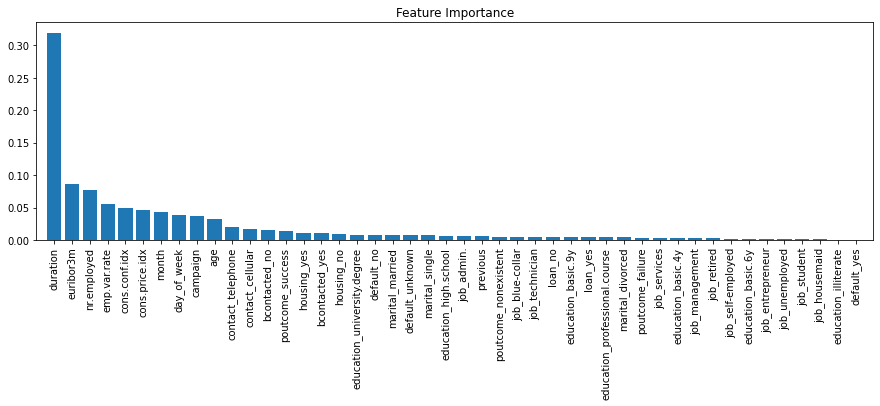

In [ ]:
# Feature Importance using RandomForest Classifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=200,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_res, y_res)

feat_labels =  X_train.columns

importances=forest.feature_importances_

print(importances.shape)

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.figure(figsize=(15,4))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

The above plot shows that duration of the customer call with the agent, social economic factors, month of contact, week day the customer was contacted and number of contacts with customer performed during campaign are major determinants.

# Section 7 : Approach 1 - MLP and RandomForest Classifier Without SMOTE

**MLP Classifier**

In [ ]:
# MLP Classifier
mlp = MLPClassifier(verbose = False, hidden_layer_sizes=(50,50,50), batch_size = 100, \
                          max_iter=500, solver='sgd', activation='logistic',\
                          learning_rate = 'constant', learning_rate_init = 0.1, random_state=1)

mlp.fit(X_train_std,y_train)

predictions_mlp = mlp.predict(X_test_std)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_mlp))
print(classification_report(y_test,predictions_mlp))
auc_mlp = roc_auc_score(y_test, mlp.predict_proba(X_test_std)[:,1])
print(auc_mlp)

[[9518  679]
 [ 599  678]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     10197
           1       0.50      0.53      0.51      1277

    accuracy                           0.89     11474
   macro avg       0.72      0.73      0.73     11474
weighted avg       0.89      0.89      0.89     11474

0.8976766163893153


**RandomForest Classifier**

In [ ]:
# RandomForest Classifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=200,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_std, y_train)
predictions_rf = forest.predict(X_test_std)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_rf))
print(classification_report(y_test,predictions_rf))
auc_rf = roc_auc_score(y_test, forest.predict_proba(X_test_std)[:,1])
print(auc_rf)

[[9861  336]
 [ 719  558]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10197
           1       0.62      0.44      0.51      1277

    accuracy                           0.91     11474
   macro avg       0.78      0.70      0.73     11474
weighted avg       0.90      0.91      0.90     11474

0.9358194085520722


# Section 8 : Approach 2 - Classifiers with SMOTE

**MLP Classifier**

In [ ]:
# MLP Classifier with SMOTE
mlp_smote = MLPClassifier(verbose = False, hidden_layer_sizes=(50,50,50), batch_size = 100, \
                          max_iter=500, solver='sgd', activation='logistic',\
                          learning_rate = 'constant', learning_rate_init = 0.1, random_state=1)
mlp_smote.fit(X_res,y_res)

predictions_mlp_smote = mlp_smote.predict(X_test_std)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_mlp_smote))
print(classification_report(y_test,predictions_mlp_smote))
auc_mlp_smote = roc_auc_score(y_test, mlp_smote.predict_proba(X_test_std)[:,1])
print(auc_mlp_smote)

[[9311  886]
 [ 514  763]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10197
           1       0.46      0.60      0.52      1277

    accuracy                           0.88     11474
   macro avg       0.71      0.76      0.73     11474
weighted avg       0.89      0.88      0.88     11474

0.8774544757240853


**RandomForest Classifier**

In [ ]:
# RF Classifier with SMOTE

forest_smote = RandomForestClassifier(criterion='gini',
                                n_estimators=200,
                                random_state=1,
                                n_jobs=2)
forest_smote.fit(X_res, y_res)

predictions_rf_smote = forest_smote.predict(X_test_std)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_rf_smote))
print(classification_report(y_test,predictions_rf_smote))
auc_rf_smote = roc_auc_score(y_test, forest_smote.predict_proba(X_test_std)[:,1])
print(auc_rf_smote)

[[9647  550]
 [ 534  743]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10197
           1       0.57      0.58      0.58      1277

    accuracy                           0.91     11474
   macro avg       0.76      0.76      0.76     11474
weighted avg       0.91      0.91      0.91     11474

0.9372900454622635


# Section 7 : Approach 3 - Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_
pca.explained_variance_ratio_.shape


(46,)

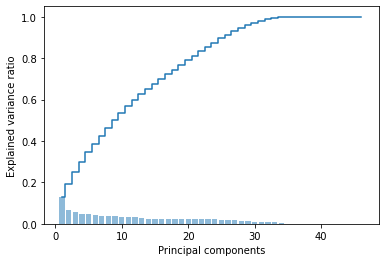

In [ ]:
# Check the plot for explained variance

plt.bar(range(1, 47), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 47), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
# Checking explained variance ratio for  optimal number of components to proceed
for i in (5,10,12,15,20,25,30):
    pca = PCA(n_components=i)
    X_train_transformed = pca.fit_transform(X_train_std)
    print("With {} components, explained variance is {} ".format(i,round(np.sum(np.sort(pca.explained_variance_ratio_))*100,2)))

With 5 components, explained variance is 34.5 
With 10 components, explained variance is 53.33 
With 12 components, explained variance is 59.76 
With 15 components, explained variance is 67.29 
With 20 components, explained variance is 78.9 
With 25 components, explained variance is 89.48 
With 30 components, explained variance is 97.03 


In [ ]:
# Choosing 30 components
pca = PCA(n_components=30)
X_train_transformed = pca.fit_transform(X_train_std)
X_test_transformed = pca.transform(X_test_std)

In [ ]:
# MLP Classifier with PCA
mlp_pca = MLPClassifier(verbose = False, hidden_layer_sizes=(50,50,50), batch_size = 100, \
                          max_iter=500, solver='sgd', activation='logistic',\
                          learning_rate = 'constant', learning_rate_init = 0.1, random_state=1)
mlp_pca.fit(X_train_transformed,y_train)

MLPClassifier(activation='logistic', batch_size=100,
              hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1,
              max_iter=500, random_state=1, solver='sgd')

In [ ]:
predictions_mlp_pca = mlp_pca.predict(X_test_transformed)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_mlp_pca))
print(classification_report(y_test,predictions_mlp_pca))

[[9670  527]
 [ 683  594]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10197
           1       0.53      0.47      0.50      1277

    accuracy                           0.89     11474
   macro avg       0.73      0.71      0.72     11474
weighted avg       0.89      0.89      0.89     11474



In [ ]:
auc_mlp_pca = roc_auc_score(y_test, mlp_pca.predict_proba(X_test_transformed)[:,1])
print(auc_mlp_pca)

0.8861600318671277


In [ ]:
# RandomForest Classifier with PCA
forest_pca = RandomForestClassifier(criterion='gini',
                                n_estimators=200,
                                random_state=1,
                                n_jobs=2)
forest_pca.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=2, random_state=1)

In [ ]:
predictions_rf_pca = forest_pca.predict(X_test_transformed)

In [ ]:
# Model Evaluation
print(confusion_matrix(y_test,predictions_rf_pca))
print(classification_report(y_test,predictions_rf_pca))

[[9886  311]
 [ 804  473]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10197
           1       0.60      0.37      0.46      1277

    accuracy                           0.90     11474
   macro avg       0.76      0.67      0.70     11474
weighted avg       0.89      0.90      0.89     11474



In [ ]:
auc_rf_pca = roc_auc_score(y_test, forest_pca.predict_proba(X_test_transformed)[:,1])
print(auc_rf_pca)

0.9186229401387804


# Section 8 : Metrics Comparison

In [ ]:
# Get Classification Reports for all the classifiers tried above

report_mlp = pd.DataFrame(classification_report(y_test,predictions_mlp, output_dict=True))
report_rf = pd.DataFrame(classification_report(y_test,predictions_rf, output_dict=True))
report_mlp_smote = pd.DataFrame(classification_report(y_test,predictions_mlp_smote, output_dict=True))
report_rf_smote = pd.DataFrame(classification_report(y_test,predictions_rf_smote, output_dict=True))
report_mlp_pca = pd.DataFrame(classification_report(y_test,predictions_mlp_pca, output_dict=True))
report_rf_pca = pd.DataFrame(classification_report(y_test,predictions_rf_pca, output_dict=True))

# Combine the accuracy metric
accuracy = pd.DataFrame()
accuracy['Plain MLP'] = report_mlp['accuracy']
accuracy['Plain RF'] = report_rf['accuracy']
accuracy['MLP with SMOTE'] = report_mlp_smote['accuracy']
accuracy['RF with SMOTE'] = report_rf_smote['accuracy']
accuracy['MLP with PCA'] = report_mlp_pca['accuracy']
accuracy['RF with PCA'] = report_rf_pca['accuracy']
#accuracy = accuracy[:1].reset_index(drop=True)
accuracy = accuracy[:1]
accuracy = accuracy.rename(index={'precision': 'accuracy'})


In [ ]:
# Get the metrics specific to "Yes" subscription
metrics_yes_sub = pd.DataFrame()
metrics_yes_sub['Plain MLP'] = report_mlp['1']
metrics_yes_sub['Plain RF'] = report_rf['1']
metrics_yes_sub['MLP with SMOTE'] = report_mlp_smote['1']
metrics_yes_sub['RF with SMOTE'] = report_rf_smote['1']
metrics_yes_sub['MLP with PCA'] = report_mlp_pca['1']
metrics_yes_sub['RF with PCA'] = report_rf_pca['1']
metrics_yes_sub.drop(['support'], inplace = True)
metrics_yes_sub=pd.concat([metrics_yes_sub,accuracy])
metrics_yes_sub.T

,precision,recall,f1-score,accuracy
Plain MLP,0.499632,0.530932,0.514806,0.888618
Plain RF,0.624161,0.436962,0.514049,0.908053
MLP with SMOTE,0.462705,0.597494,0.521531,0.877985
RF with SMOTE,0.574633,0.581832,0.578210,0.905526
MLP with PCA,0.529884,0.465153,0.495413,0.894544
RF with PCA,0.603316,0.370399,0.459000,0.902824


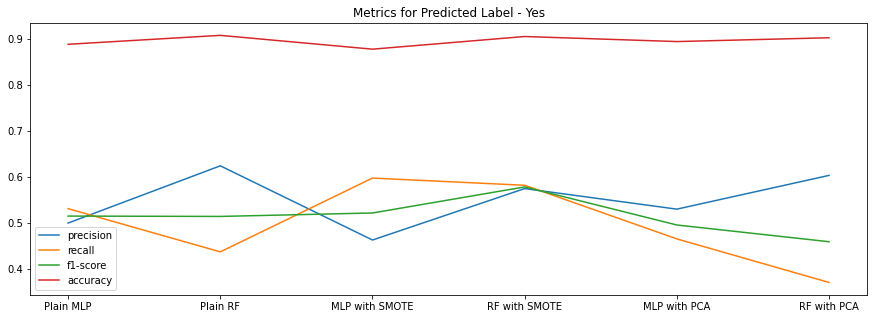

In [ ]:
# Line plot - Metrics for 'Yes' subscription
metrics_yes_sub.T.plot(kind='line',figsize=(15,5))
plt.title('Metrics for Predicted Label - Yes')
plt.show()

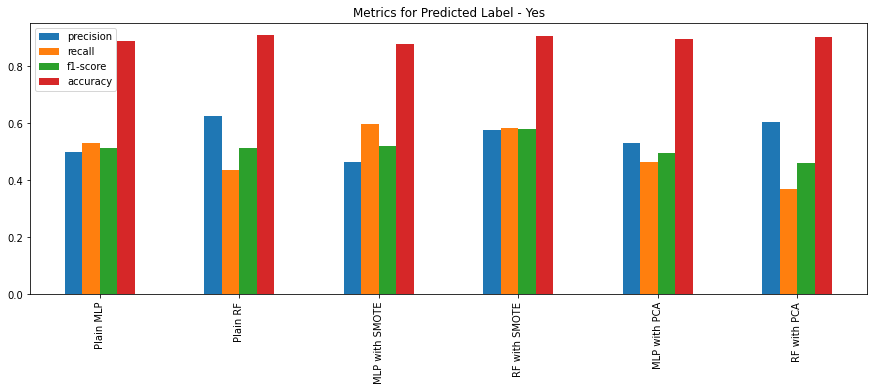

In [ ]:
# Bar plot - Metrics for 'Yes' subscription
metrics_yes_sub.T.plot(kind='bar',figsize=(15,5))
plt.title('Metrics for Predicted Label - Yes')
plt.show()

In [ ]:
metrics_no_sub = pd.DataFrame()
metrics_no_sub['Plain MLP'] = report_mlp['0']
metrics_no_sub['Plain RF'] = report_rf['0']
metrics_no_sub['MLP with SMOTE'] = report_mlp_smote['0']
metrics_no_sub['RF with SMOTE'] = report_rf_smote['0']
metrics_no_sub['MLP with PCA'] = report_mlp_pca['0']
metrics_no_sub['RF with PCA'] = report_rf_pca['0']
metrics_no_sub=pd.concat([metrics_no_sub,accuracy])
metrics_no_sub.drop(['support'], inplace = True)
metrics_no_sub

,Plain MLP,Plain RF,MLP with SMOTE,RF with SMOTE,MLP with PCA,RF with PCA
precision,0.940793,0.932042,0.947684,0.947549,0.934029,0.924790
recall,0.933412,0.967049,0.913112,0.946063,0.948318,0.969501
f1-score,0.937088,0.949223,0.930077,0.946805,0.941119,0.946618
accuracy,0.888618,0.908053,0.877985,0.905526,0.894544,0.902824


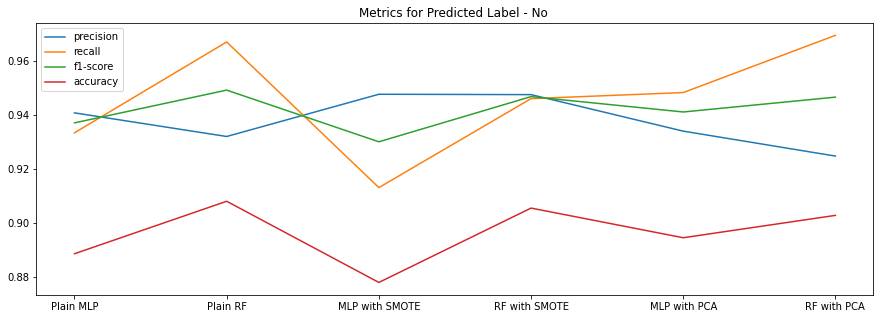

In [ ]:
# Line plot - Metrics for 'No' subscription
metrics_no_sub.T.plot(kind='line',figsize=(15,5))
plt.title('Metrics for Predicted Label - No ')
plt.show()

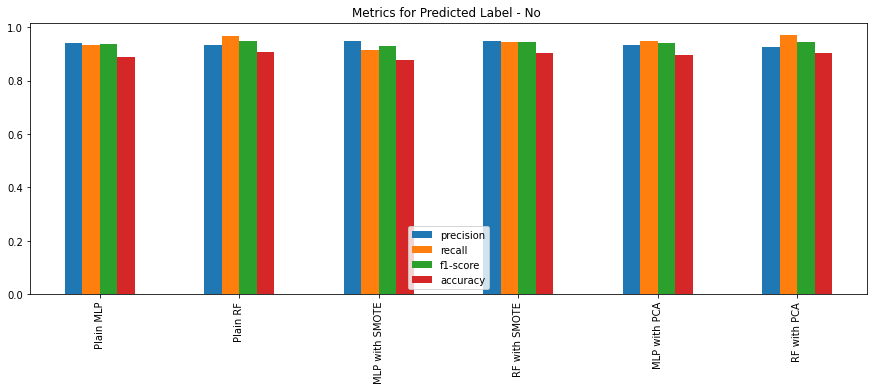

In [ ]:
# Bar plot - Metrics for 'No' subscription
metrics_no_sub.T.plot(kind='bar',figsize=(15,5))
plt.title('Metrics for Predicted Label - No ')
plt.show()

Some key findings from the above plot

*   Overall accuracy is almost the same across all the three approaches but Random Forest with and without SMOTE has the highest accuracy of 91% on test data
*   Notice the right balance between precision and recall for the Random Forest classifier with SMOTE approach which thereby has the highest f1-score

[Precision Vs Recall](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2)



# Section 9 : Conclusion

Bank marketing campaign dataset being a real world dataset, has been analyzed by many on kaggle. But most of the previous works focus on exploratory data analysis or on applying the classifiers and feature importance without tackling the class imbalance issue. In this project, we tried to overcome the class imbalance issue by using SMOTE, tried PCA and then applied MLP classifier and Random Forest classifier on the dataset. Apart from that, we have also tried feature importance and selection post SMOTE using L1 regularization and Random Forest Classifier. **Performance metrics of Random Forest classifier with SMOTE is more promising than the others as it has the highest F1- score and accuracy.** In this specific scenario of identifying potential customers who would subscribe to a term deposit, we believe that importance should be given to f1-score than accuracy as false negatives for customers who would subscribe (omitting a potential customer) would cost more to a bank.